# Classification with Gated Residual and Variable Selection Networks

## Introduction

This example demonstrates the use of `Gated Residual Networks (GRN)` and `Variable Selection Networks (VSN)`, proposed by Bryan Lim et al. in `Temporal Fusion Transformers (TFT) for Interpretable Multi-horizon Time Series Forecasting`, for structured data classification. GRNs give the flexibility to the model to apply non-linear processing only where needed. VSNs allow the model to softly remove any unnecessary noisy inputs which could negatively impact performance. Together, those techniques help improving the learning capacity of deep neural network models.

### Temporal Fusion Transformers (International Journal of Forecasting 2021)

<img src='./images/TFT.png' width='900'> 

## The dataset

- Dataset : United States Census Income Dataset
- Info
    - Provided by the UC Irvine Machine Learning Repository
    - Binary classification to predict whether a person is likely to be making over USD 50K a year
    - ~300K instances with 41 input features(7 numerical features, 34 categorical features)

## Setup

In [1]:
import numpy as np
import pandas as pd
import random
import os
import sys
import time
from einops import rearrange
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(72)

## Prepare the data

First we load the data from the UCI Machine Learning Repository into a Pandas DataFrame.

In [4]:
# Column names.
CSV_HEADER = [
    "age",
    "class_of_worker",
    "detailed_industry_recode",
    "detailed_occupation_recode",
    "education",
    "wage_per_hour",
    "enroll_in_edu_inst_last_wk",
    "marital_stat",
    "major_industry_code",
    "major_occupation_code",
    "race",
    "hispanic_origin",
    "sex",
    "member_of_a_labor_union",
    "reason_for_unemployment",
    "full_or_part_time_employment_stat",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "tax_filer_stat",
    "region_of_previous_residence",
    "state_of_previous_residence",
    "detailed_household_and_family_stat",
    "detailed_household_summary_in_household",
    "instance_weight",
    "migration_code-change_in_msa",
    "migration_code-change_in_reg",
    "migration_code-move_within_reg",
    "live_in_this_house_1_year_ago",
    "migration_prev_res_in_sunbelt",
    "num_persons_worked_for_employer",
    "family_members_under_18",
    "country_of_birth_father",
    "country_of_birth_mother",
    "country_of_birth_self",
    "citizenship",
    "own_business_or_self_employed",
    "fill_inc_questionnaire_for_veteran's_admin",
    "veterans_benefits",
    "weeks_worked_in_year",
    "year",
    "income_level",
]

annotation_folder = os.path.abspath(".") + "/dataset/USCI/census-income"

train_data_file = os.path.join(annotation_folder, "train_data.csv")
valid_data_file = os.path.join(annotation_folder, "valid_data.csv")
test_data_file = os.path.join(annotation_folder, "test_data.csv")

if not os.path.exists(annotation_folder):
    os.makedirs(annotation_folder)
    print('Folder creation complete!')
else:
    print('The folder already exists.')

if not os.path.isfile(train_data_file) or not os.path.isfile(valid_data_file):
    data_url = (
        "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.data.gz"
    )
    data = pd.read_csv(data_url, header=None, names=CSV_HEADER)
    data["income_level"] = data["income_level"].apply(
        lambda x: 0 if x == " - 50000." else 1
    )
    random_selection = np.random.rand(len(data.index)) <= 0.85
    train_data = data[random_selection]
    valid_data = data[~random_selection]
    train_data.to_csv(train_data_file, index=False)
    valid_data.to_csv(valid_data_file, index=False)
    print('train_data.csv creation complete!')
    print('valid_data.csv creation complete!')
else:
    train_data = pd.read_csv(train_data_file)
    valid_data = pd.read_csv(valid_data_file)
    print('train_data.csv already exists.')
    print('valid_data.csv already exists.')
print('train_data load complete!')
print('valid_data load complete!')

if not os.path.isfile(test_data_file):
    test_data_url = (
        "https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census-income.test.gz"
    )
    test_data = pd.read_csv(test_data_url, header=None, names=CSV_HEADER)
    test_data["income_level"] = test_data["income_level"].apply(
        lambda x: 0 if x == " - 50000." else 1
    )
    test_data.to_csv(test_data_file, index=False)
    print('test_data.csv creation complete!')
else:
    test_data = pd.read_csv(test_data_file)
    print('test_data.csv already exists.')
print('test_data load complete!')

print(f"Train data shape: {train_data.shape}")
print(f"Valid data shape: {valid_data.shape}")
print(f"Test data shape: {test_data.shape}")

The folder already exists.
train_data.csv already exists.
valid_data.csv already exists.
train_data load complete!
valid_data load complete!
test_data.csv already exists.
test_data load complete!
Train data shape: (169671, 42)
Valid data shape: (29852, 42)
Test data shape: (99762, 42)


In [5]:
train_data.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,income_level
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,0
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,0
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,0
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,0


## Define dataset metadata

Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.

In [6]:
# Target feature name.
TARGET_FEATURE_NAME = "income_level"
# Weight column name.
WEIGHT_COLUMN_NAME = "instance_weight"
# Numeric feature names.
NUMERIC_FEATURE_NAMES = [
    "age",
    "wage_per_hour",
    "capital_gains",
    "capital_losses",
    "dividends_from_stocks",
    "num_persons_worked_for_employer",
    "weeks_worked_in_year",
]
# Categorical features and their vocabulary lists.
# Note that we add 'v=' as a prefix to all categorical feature values to make
# sure that they are treated as strings.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    feature_name: sorted([value for value in list(train_data[feature_name].unique())])
    for feature_name in CSV_HEADER
    if feature_name
    not in list(NUMERIC_FEATURE_NAMES + [WEIGHT_COLUMN_NAME, TARGET_FEATURE_NAME])
}
# All features names.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + list(
    CATEGORICAL_FEATURES_WITH_VOCABULARY.keys()
)
# Feature default values.
COLUMN_DEFAULTS = [
    [0.0]
    if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME, WEIGHT_COLUMN_NAME]
    else ["NA"]
    for feature_name in CSV_HEADER
]

In [7]:
CATEGORICAL_FEATURES_WITH_VOCABULARY

{'class_of_worker': [' Federal government',
  ' Local government',
  ' Never worked',
  ' Not in universe',
  ' Private',
  ' Self-employed-incorporated',
  ' Self-employed-not incorporated',
  ' State government',
  ' Without pay'],
 'detailed_industry_recode': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51],
 'detailed_occupation_recode': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46],
 'education': [' 10th grade',
  ' 11th grade',
  ' 12th grade no diploma',
  ' 1st 2nd 3rd or 4th grade',
  ' 5th or 6th grade',
  '

## Configure the hyperparameters

In [8]:
params = {
    'LEARNING_RATE': 0.001,
    'WEIGHT_DECAY': 0.0001,
    'DROPOUT_RATE': 0.15,
    'BATCH_SIZE': 265,
    'NUM_WORKERS': 4,
    'PIN_MEMORY': True,
    'NUM_EPOCHS': 20,
    'ENCODING_SIZE': 16,
    'DEVICE': device
}

## Create a Dataset for training and evaluation

In [9]:
class CustomDataset(Dataset):
    def __init__(self,
                 dataframe,
                 VOCABULARY=CATEGORICAL_FEATURES_WITH_VOCABULARY,
                 FEATURE_NAMES=FEATURE_NAMES,
                 NUMERIC_FEATURE_NAMES=NUMERIC_FEATURE_NAMES,
                 TARGET_FEATURE_NAME=TARGET_FEATURE_NAME,
                 WEIGHT_COLUMN_NAME=WEIGHT_COLUMN_NAME,
                 COLUMN_DEFAULTS=COLUMN_DEFAULTS):

        data = dataframe.copy().dropna()

        for idx, feature_name in enumerate(FEATURE_NAMES):
            # data[feature_name] = data[feature_name].fillna(COLUMN_DEFAULTS[idx])
            if feature_name not in NUMERIC_FEATURE_NAMES:
                data[feature_name] = data[feature_name].map(lambda x: VOCABULARY[feature_name].index(x))

        self.weights = np.array(data.pop(WEIGHT_COLUMN_NAME), dtype=np.float32)
        self.targets = np.array(data.pop(TARGET_FEATURE_NAME), dtype=np.int)
        self.data = np.array(data[FEATURE_NAMES])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.from_numpy(self.data[idx])
        target_index = torch.as_tensor(self.targets[idx])
        weight = torch.as_tensor(self.weights[idx])
        return features, target_index, weight

In [10]:
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

train_loader = DataLoader(dataset=train_dataset,
                          shuffle=True,
                          batch_size=params['BATCH_SIZE'],
                          pin_memory=params['PIN_MEMORY'],
                          num_workers=params['NUM_WORKERS'])
valid_loader = DataLoader(dataset=valid_dataset,
                          shuffle=True,
                          batch_size=params['BATCH_SIZE'],
                          pin_memory=params['PIN_MEMORY'],
                          num_workers=params['NUM_WORKERS'])
test_loader = DataLoader(dataset=test_dataset,
                         shuffle=False,
                         batch_size=params['BATCH_SIZE'],
                         pin_memory=params['PIN_MEMORY'],
                         num_workers=params['NUM_WORKERS'])

In [11]:
Counter(train_data[TARGET_FEATURE_NAME])

Counter({0: 159159, 1: 10512})

In [12]:
Counter(valid_data[TARGET_FEATURE_NAME])

Counter({0: 27982, 1: 1870})

In [13]:
print(next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

torch.Size([265, 40]) torch.Size([265])


In [14]:
input_shape = next(iter(train_loader))[0].shape

## Implement the Gated Linear Unit

Gated Linear Units (GLUs) provide the flexibility to suppress input that are not relevant for a given task.

In [15]:
class GatedLinearUnit(nn.Module):
    def __init__(self, input_shape, units):
        super(GatedLinearUnit, self).__init__()
        self.linear = nn.Linear(input_shape, units)
        self.sigmoid = nn.Sequential(
            nn.Linear(input_shape, units),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

## Implement the Gated Residual network

The Gated Residual Network (GRN) works as follows:

1. pplies the nonlinear ELU transformation to the inputs.
2. Applies linear transformation followed by dropout.
3. Applies GLU and adds the original inputs to the output of the GLU to perform skip (residual) connection.
4. Applies layer normalization and produces the output.

<img src='./images/GRN.png' width='400'> 

In [16]:
class GatedResidualNetwork(nn.Module):
    def __init__(self, input_size, units, dropout_rate):
        super(GatedResidualNetwork, self).__init__()
        self.units = units
        self.elu_dense = nn.Sequential(
            nn.Linear(input_size, units),
            nn.ELU()
        )
        self.linear_dense = nn.Linear(units, units)
        self.dropout = nn.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units, units)
        self.layer_norm = nn.LayerNorm(units)
        self.project = nn.Linear(input_size, units)

    def forward(self, inputs):
        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x


In [17]:
summary(GatedResidualNetwork(16, 16, 0.01), [265, 40, 16])

Layer (type:depth-idx)                   Output Shape              Param #
GatedResidualNetwork                     --                        --
├─Sequential: 1-1                        [265, 40, 16]             --
│    └─Linear: 2-1                       [265, 40, 16]             272
│    └─ELU: 2-2                          [265, 40, 16]             --
├─Linear: 1-2                            [265, 40, 16]             272
├─Dropout: 1-3                           [265, 40, 16]             --
├─GatedLinearUnit: 1-4                   [265, 40, 16]             --
│    └─Linear: 2-3                       [265, 40, 16]             272
│    └─Sequential: 2-4                   [265, 40, 16]             --
│    │    └─Linear: 3-1                  [265, 40, 16]             272
│    │    └─Sigmoid: 3-2                 [265, 40, 16]             --
├─LayerNorm: 1-5                         [265, 40, 16]             32
Total params: 1,120
Trainable params: 1,120
Non-trainable params: 0
Total mult-ad

## Implement the Variable Selection Network

The Variable Selection Network (VSN) works as follows:

1. Applies a GRN to each feature individually.
2. Applies a GRN on the concatenation of all the features, followed by a softmax to produce feature weights.
3. Produces a weighted sum of the output of the individual GRN.

Note that the output of the VSN is [batch_size, encoding_size], regardless of the number of the input features.

<img src='./images/Variable_Selection_Network.png' width='400'> 

In [18]:
class VariableSelection(nn.Module):
    def __init__(self, input_size, num_features, units, dropout_rate):
        super(VariableSelection, self).__init__()
        self.num_features = num_features
        self.grns = nn.ModuleList()
        # Create a GRN for each feature independently
        for idx in range(num_features):
            grn = GatedResidualNetwork(input_size, units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(input_size*num_features, units, dropout_rate)
        self.softmax = nn.Sequential(
            nn.Linear(units, num_features),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        v = rearrange(inputs, 'b n d -> b (n d)')
        v = self.grn_concat(v)
        v = self.softmax(v).unsqueeze(1)

        x = []
        for idx in range(self.num_features):
            x.append(self.grns[idx](inputs[:,idx]))
        x = torch.stack(x, dim=1)
        outputs = torch.matmul(v, x)
        return outputs

In [19]:
summary(VariableSelection(16, 40, 16, 0.01), [256, 40, 16])

Layer (type:depth-idx)                   Output Shape              Param #
VariableSelection                        --                        --
├─ModuleList: 1-1                        --                        --
├─GatedResidualNetwork: 1-2              [256, 16]                 --
│    └─Sequential: 2-1                   [256, 16]                 --
│    │    └─Linear: 3-1                  [256, 16]                 10,256
│    │    └─ELU: 3-2                     [256, 16]                 --
│    └─Linear: 2-2                       [256, 16]                 272
│    └─Dropout: 2-3                      [256, 16]                 --
│    └─Linear: 2-4                       [256, 16]                 10,256
│    └─GatedLinearUnit: 2-5              [256, 16]                 --
│    │    └─Linear: 3-3                  [256, 16]                 272
│    │    └─Sequential: 3-4              [256, 16]                 272
│    └─LayerNorm: 2-6                    [256, 16]                 32
├─Se

## Create Gated Residual and Variable Selection Networks model

In [20]:
class create_model(nn.Module):
    def __init__(self,
                 params,
                 FEATURE_NAMES=FEATURE_NAMES,
                 CATEGORICAL_FEATURES_WITH_VOCABULARY=CATEGORICAL_FEATURES_WITH_VOCABULARY, ):
        super(create_model, self).__init__()
        self.encoding_size = params['ENCODING_SIZE']
        self.dropout_rate = params['DROPOUT_RATE']
        self.device = params['DEVICE']
        self.num_features = len(FEATURE_NAMES)
        self.num_cat_features = len(CATEGORICAL_FEATURES_WITH_VOCABULARY)
        self.num_numeric_features = self.num_features - self.num_cat_features
        self.embedding_layers = nn.ModuleList()
        self.linear_layers = nn.ModuleList()

        for feature in FEATURE_NAMES:
            if feature in CATEGORICAL_FEATURES_WITH_VOCABULARY.keys():
                emb = nn.Embedding(len(CATEGORICAL_FEATURES_WITH_VOCABULARY[feature]), self.encoding_size).to(self.device)
                self.embedding_layers.append(emb)
            else:
                emb = nn.Linear(1, self.encoding_size).to(self.device)
                self.linear_layers.append(emb)

        self.variable_selection = VariableSelection(self.encoding_size,
                                          self.num_features,
                                          self.encoding_size,
                                          self.dropout_rate)

        self.linear = nn.Linear(self.encoding_size, 1)

    def forward(self, inputs):
        numeric_vectors = []
        for i in range(self.num_numeric_features):
            emb = self.linear_layers[i](inputs[:, i].view(inputs.size(0), -1, 1).float().to(self.device))
            numeric_vectors.append(emb)
        numeric_vectors = torch.cat(numeric_vectors, dim=1)

        categoical_vectors = []
        for i in range(self.num_cat_features):
            emb = self.embedding_layers[i](inputs[:, self.num_numeric_features+i].view(inputs.size(0), -1).long().to(self.device))
            categoical_vectors.append(emb)
        categoical_vectors = torch.cat(categoical_vectors, dim=1)
        embeddings = torch.cat([numeric_vectors,categoical_vectors], dim=1)

        features = self.variable_selection(embeddings)
        output = self.linear(features)

        return output.squeeze(1).type(torch.FloatTensor).to(self.device)


In [21]:
model = create_model(params).to(device)

In [22]:
summary(model, input_shape)

Layer (type:depth-idx)                        Output Shape              Param #
create_model                                  --                        --
├─ModuleList: 1-1                             --                        --
├─ModuleList: 1-2                             --                        --
├─VariableSelection: 1                        --                        --
│    └─ModuleList: 2-1                        --                        --
├─ModuleList: 1-2                             --                        --
│    └─Linear: 2-2                            [265, 1, 16]              32
│    └─Linear: 2-3                            [265, 1, 16]              32
│    └─Linear: 2-4                            [265, 1, 16]              32
│    └─Linear: 2-5                            [265, 1, 16]              32
│    └─Linear: 2-6                            [265, 1, 16]              32
│    └─Linear: 2-7                            [265, 1, 16]              32
│    └─Linear: 2-8  

In [23]:
optimizer = optim.Adam(model.parameters(), lr=params['LEARNING_RATE'])
loss_fn = nn.BCEWithLogitsLoss()

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [25]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [26]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None, progress_display=False):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    Acc = AverageMeter('Acc', ':6.2f')
    progress = ProgressMeter(
        len(train_data),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()
    end = time.time()
    for idx, [x, y, w] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()

        input = x
        target = y.unsqueeze(1).to(device, dtype=torch.float32)

        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model(input)
            train_loss = loss_fn(predictions, target)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
        acc = binary_acc(predictions, target)
        Acc.update(acc, input.size(0))
        losses.update(train_loss.item(), input.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if progress_display == True and idx % 50 == 0:
            progress.display(idx)

    return losses.avg, Acc.avg

In [27]:
def validation(model, val_data, loss_fn):
    losses = AverageMeter('Loss', ':.4e')
    Acc = AverageMeter('Acc', ':6.2f')
    model.eval()
    val_loss = 0
    for idx, [x, y, w] in enumerate(val_data):
        input = x
        target = y.unsqueeze(1).to(device, dtype=torch.float32)
        with torch.no_grad():
            predictions = model(input)
            val_loss = loss_fn(predictions, target)
        acc = binary_acc(predictions, target)
        Acc.update(acc, input.size(0))
        losses.update(val_loss.item(), input.size(0))

    return losses.avg, Acc.avg

In [28]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [29]:
%%time
best = {"acc": sys.float_info.min}
history = dict()
early_stopping = EarlyStopping(patience=5, verbose=1)

for epoch in range(1, params['NUM_EPOCHS']+1):
    epoch_loss, epoch_acc = train(model, train_loader, optimizer, loss_fn, use_fp16=False)
    val_loss, val_acc = validation(model, valid_loader, loss_fn)

    history.setdefault('loss', []).append(epoch_loss)
    history.setdefault('val_loss', []).append(val_loss)
    history.setdefault('accuracy', []).append(epoch_acc)
    history.setdefault('val_accuracy', []).append(val_acc)

    print(f"[Train] Epoch : {epoch:^3}"
          f"  Train Loss: {epoch_loss:.4}"
          f"  Train Acc: {epoch_acc:.4}"
          f"  Valid Loss: {val_loss:.4}"
          f"  Valid Acc: {val_acc:.4}")

    if val_acc > best["acc"]:
        best["state"] = model.state_dict()
        best["acc"] = val_acc
        best["epoch"] = epoch
    if early_stopping.validate(val_loss):
        break

[Train] Epoch :  1   Train Loss: 0.1719  Train Acc: 94.28  Valid Loss: 0.1335  Valid Acc: 94.71
[Train] Epoch :  2   Train Loss: 0.1304  Train Acc: 94.94  Valid Loss: 0.1301  Valid Acc: 94.9
[Train] Epoch :  3   Train Loss: 0.1281  Train Acc: 95.0  Valid Loss: 0.1298  Valid Acc: 95.0
[Train] Epoch :  4   Train Loss: 0.1268  Train Acc: 95.03  Valid Loss: 0.1288  Valid Acc: 94.94
[Train] Epoch :  5   Train Loss: 0.1256  Train Acc: 95.07  Valid Loss: 0.1271  Valid Acc: 95.04
[Train] Epoch :  6   Train Loss: 0.1248  Train Acc: 95.08  Valid Loss: 0.1272  Valid Acc: 95.06
[Train] Epoch :  7   Train Loss: 0.1239  Train Acc: 95.11  Valid Loss: 0.1264  Valid Acc: 95.06
[Train] Epoch :  8   Train Loss: 0.1227  Train Acc: 95.15  Valid Loss: 0.1259  Valid Acc: 95.06
[Train] Epoch :  9   Train Loss: 0.122  Train Acc: 95.16  Valid Loss: 0.1253  Valid Acc: 95.06
[Train] Epoch : 10   Train Loss: 0.1212  Train Acc: 95.21  Valid Loss: 0.1246  Valid Acc: 95.13
[Train] Epoch : 11   Train Loss: 0.12  Train

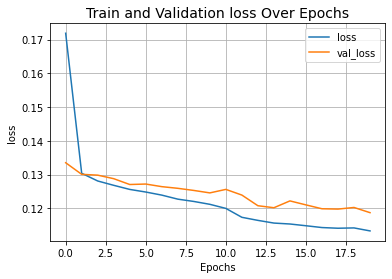

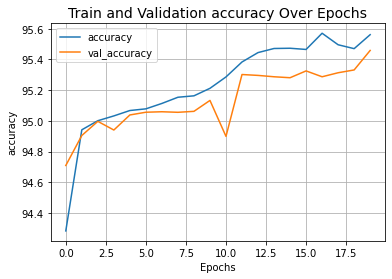

In [30]:
def plot_result(item):
    plt.plot(history[item], label=item)
    plt.plot(history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

## Test

In [45]:
losses = AverageMeter('Loss', ':.4e')
Acc = AverageMeter('Acc', ':6.2f')

model.eval()
test_loss = 0
predic = []
for idx, [x, y, w] in enumerate(test_loader):
    input = x
    target = y.unsqueeze(1).to(device, dtype=torch.float32)
    with torch.no_grad():
        predictions = model(input)
        test_loss = loss_fn(predictions, target)
    predic.extend(torch.round(torch.sigmoid(predictions)).detach().cpu().squeeze().tolist())
    acc = binary_acc(predictions, target)
    Acc.update(acc, input.size(0))
    losses.update(test_loss.item(), input.size(0))

print(f'Loss : {losses.avg}, Acc : {Acc.avg}')

Loss : 0.11532411552146064, Acc : 95.53800964355469


In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_data[TARGET_FEATURE_NAME].tolist(), predic)

array([[92558,  1018],
       [ 3392,  2794]])

---